# Chapter 14: The General Linear Model

In [1]:
library(tidyverse)
library(ggplot2)
library(fivethirtyeight)
library(caret)
library(MASS)
library(cowplot)
theme_set(theme_minimal(base_size = 14))

library(knitr)

set.seed(123456) # set random seed to exactly replicate results
opts_chunk$set(tidy.opts=list(width.cutoff=80))
options(tibble.width = 60)

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(Weight) %>%
  subset(Age>=18)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Some larger datasets need to be installed separately, like senators and
house_district_forecast. To install these, we recommend you install the
fivethirtyeightdata package by running:
install.packages('fivethirtyeightdata', repos =
'https://fivethirtyeightdata.github.io/drat/', type = 'source')

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




## Figure 14.1

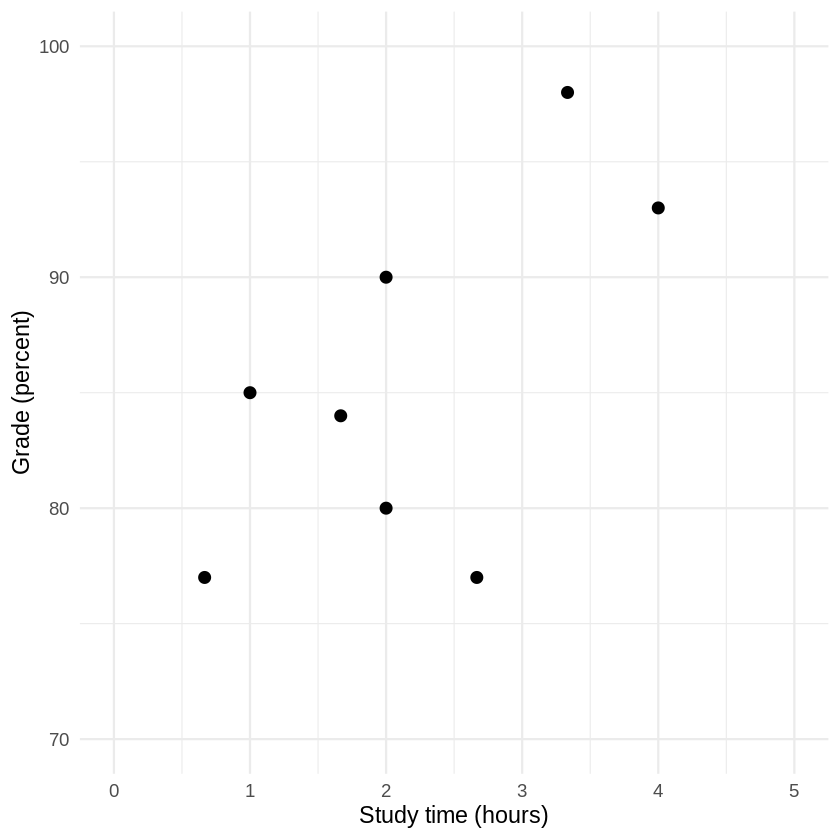

In [2]:
# create simulated data for example
set.seed(12345)

# the number of points that having a prior class increases grades
betas <- c(6, 5)

df <-
  tibble(
    studyTime = c(2, 3, 5, 6, 6, 8, 10, 12) / 3,
    priorClass = c(0, 1, 1, 0, 1, 0, 1, 0)
  ) %>%
  mutate(
    grade =
      studyTime * betas[1] +
      priorClass * betas[2] +
      round(rnorm(8, mean = 70, sd = 5))
  )

p <- ggplot(df,aes(studyTime,grade)) +
  geom_point(size=3) +
  xlab('Study time (hours)') +
  ylab('Grade (percent)') +
  xlim(0,5) +
  ylim(70,100)

print(p)

## Correlation test

In [3]:
# compute correlation between grades and study time
corTestResult <- cor.test(df$grade, df$studyTime)
corTestResult


	Pearson's product-moment correlation

data:  df$grade and df$studyTime
t = 2.0134, df = 6, p-value = 0.09073
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1261283  0.9255245
sample estimates:
      cor 
0.6349813 


## Figure 14.2

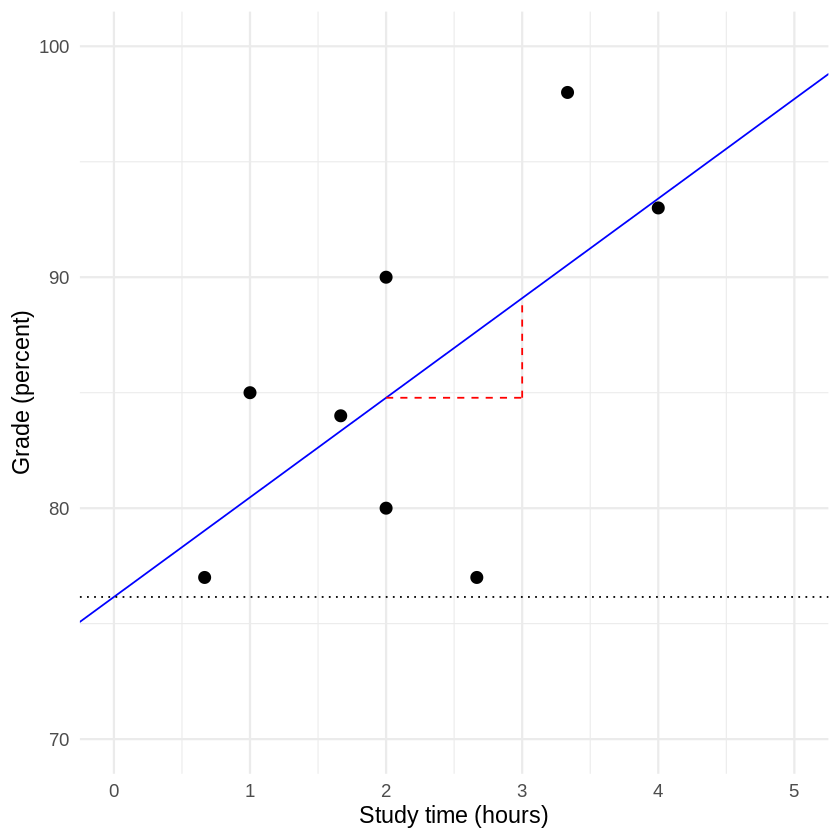

In [4]:
lmResult <- lm(grade~studyTime,data=df)

p2 <- p+geom_abline(slope=lmResult$coefficients[2],
                  intercept=lmResult$coefficients[1],
                  color='blue')


p3 <- p2 +
  geom_hline(yintercept=lmResult$coefficients[1],color='black',linewidth=0.5,linetype='dotted') +
  annotate('segment',x=2,xend=3,color='red',linetype='dashed',
           y=predict(lmResult,newdata=data.frame(studyTime=2))[1],
           yend=predict(lmResult,newdata=data.frame(studyTime=2))[1]) +
   annotate('segment',x=3,xend=3,color='red',linetype='dashed',
           y=predict(lmResult,newdata=data.frame(studyTime=2))[1],
           yend=predict(lmResult,newdata=data.frame(studyTime=3))[1])

print(p3)

## Table 14.1

In [5]:
# create simulated data for regression to the mean example

nstudents <- 100

readingScores <- data.frame(
  #random normal distribution of scores for test 1
  test1 = rnorm(n = nstudents, mean = 0, sd = 1) * 10 + 100,
  #random normal distribution of scores for test 2
  test2 = rnorm(n = nstudents, mean = 0, sd = 1) * 10 + 100
)

# select the students in the bottom 25% on the first test
cutoff <- quantile(readingScores$test1, 0.25)

readingScores <-
  readingScores %>%
  mutate(badTest1 = test1 < cutoff) %>%
  dplyr::filter(badTest1 == TRUE) %>%
  summarize(
    `Test 1` = mean(test1),
    `Test 2` = mean(test2)
  )
readingScores = as.data.frame(t(readingScores)) %>% rename(Score = V1)
kable(readingScores, caption='Reading scores for Test 1 (which is lower, because it was the basis for selecting the students) and Test 2 (which is higher because it was independent from Test 1).')



Table: Reading scores for Test 1 (which is lower, because it was the basis for selecting the students) and Test 2 (which is higher because it was independent from Test 1).

|       |     Score|
|:------|---------:|
|Test 1 |  87.88674|
|Test 2 | 100.72289|

## Linear model output

In [6]:
summary(lmResult)


Call:
lm(formula = grade ~ studyTime, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.656  -2.719   0.125   4.703   7.469 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   76.156      5.161  14.756 6.09e-06 ***
studyTime      4.313      2.142   2.013   0.0907 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.386 on 6 degrees of freedom
Multiple R-squared:  0.4032,	Adjusted R-squared:  0.3037 
F-statistic: 4.054 on 1 and 6 DF,  p-value: 0.09073


## Linear regression output for study time and prior class

In [7]:
# perform linear regression for study time and prior class

# must change priorClass to a factor variable
df$priorClass <- as.factor(df$priorClass)

lmResultTwoVars <- lm(grade ~ studyTime + priorClass, data = df)
summary(lmResultTwoVars)


Call:
lm(formula = grade ~ studyTime + priorClass, data = df)

Residuals:
       1        2        3        4        5        6        7        8 
 3.58333  0.75000 -3.58333 -0.08333  0.75000 -6.41667  2.08333  2.91667 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   70.083      3.768  18.600 8.27e-06 ***
studyTime      5.000      1.366   3.661   0.0146 *  
priorClass1    9.167      2.879   3.184   0.0244 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.021 on 5 degrees of freedom
Multiple R-squared:  0.8028,	Adjusted R-squared:  0.724 
F-statistic: 10.18 on 2 and 5 DF,  p-value: 0.01726


## Figure 14.3

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


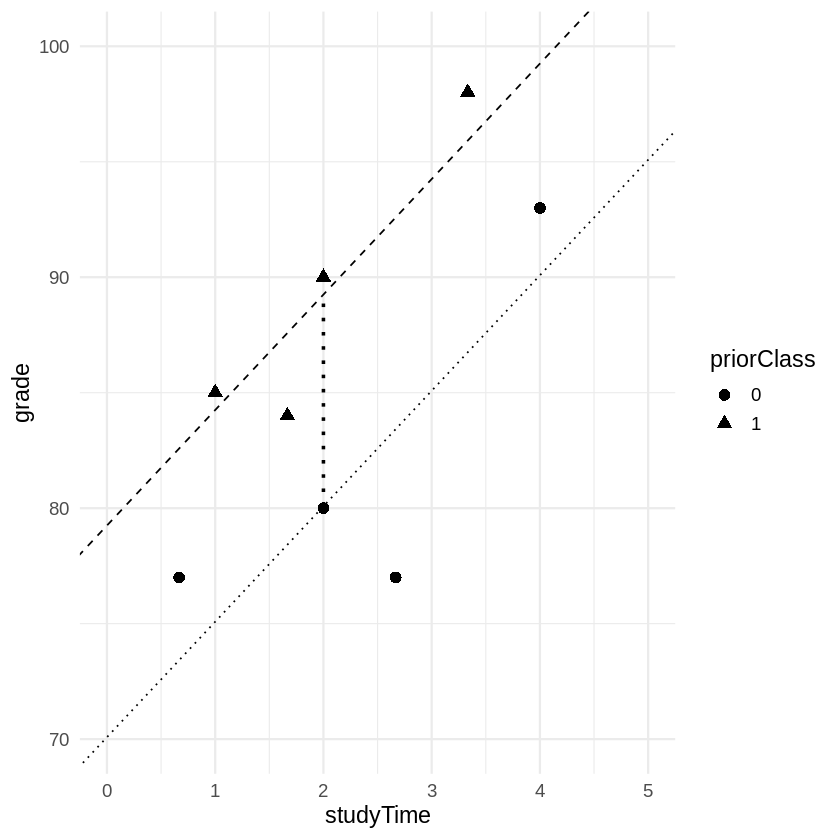

In [8]:
p <- ggplot(df,aes(studyTime,grade,shape=priorClass)) +
  geom_point(size=3) + xlim(0,5) + ylim(70,100)


p <- p+
  geom_abline(slope=lmResultTwoVars$coefficients[2],
              intercept=lmResultTwoVars$coefficients[1],linetype='dotted')


p <- p+
  geom_abline(slope=lmResultTwoVars$coefficients[2],
              intercept=lmResultTwoVars$coefficients[1]+
                lmResultTwoVars$coefficients[3],
              linetype='dashed')

p <- p+
  annotate('segment',x=2,xend=2,
           y=lmResultTwoVars$coefficients[1]+
             2*lmResultTwoVars$coefficients[2],
           yend=lmResultTwoVars$coefficients[1]+
             lmResultTwoVars$coefficients[3] +
             2*lmResultTwoVars$coefficients[2],
           linetype='dotted',size=1) +
  scale_color_discrete(
    limits = c(0, 1),
    labels = c("No", "Yes")
  ) +
  labs(
    color = "Previous course"
  )
print(p)

## Figure 14.4

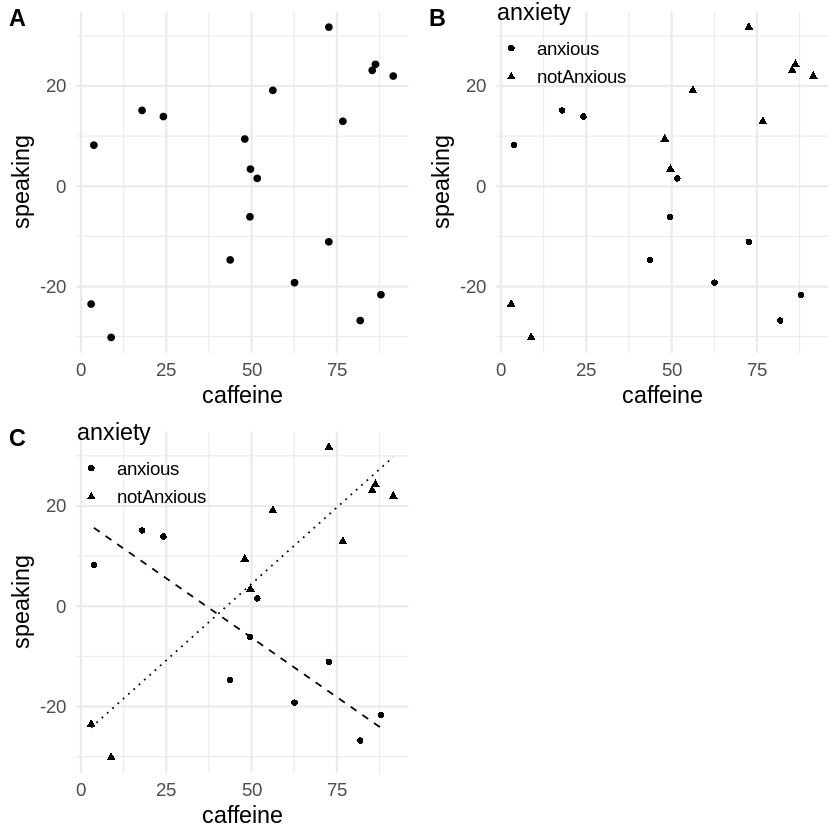

In [9]:
set.seed(1234567)

df <-
  data.frame(
    group=c(rep(-1,10),
            rep(1,10)
          )
  ) %>%
  mutate(caffeine=runif(n())*100) %>%
  mutate(speaking=0.5*caffeine*-group + group*20 + rnorm(20)*10) %>%
  mutate(anxiety=ifelse(group==1,'anxious','notAnxious'))

# perform linear regression with caffeine as independent variable
lmResultCaffeine <- lm(speaking ~ caffeine, data = df)

# compute linear regression adding anxiety to model
lmResultCafAnx <- lm(speaking ~ caffeine + anxiety, data = df)

# compute linear regression including caffeine X anxiety interaction
lmResultInteraction <- lm(
  speaking ~ caffeine + anxiety + caffeine * anxiety,
  data = df
)

p1 <- ggplot(df,aes(caffeine,speaking)) +
  geom_point()

p2 <- ggplot(df,aes(caffeine,speaking,shape=anxiety)) +
  geom_point() +
  theme(legend.position = c(0.2, 0.9))

df_anx <-
  df %>%
  subset(anxiety=='anxious') %>%
  mutate(y=lmResultInteraction$fitted.values[df$anxiety=='anxious'])

df_notanx <-
  df %>%
  subset(anxiety=='notAnxious')%>%
  mutate(y=lmResultInteraction$fitted.values[df$anxiety=='notAnxious'])



p3 <- ggplot(df,aes(caffeine,speaking,shape=anxiety)) +
   geom_point() +
   theme(legend.position = c(0.2, 0.9)) +
  geom_line(data=df_anx,
             aes(caffeine,y),linetype='dashed') +
  geom_line(data=df_notanx,
             aes(caffeine,y),linetype='dotted')
plot_grid(p1, p2, p3, labels='AUTO')

## Linear model for caffeine

In [10]:
summary(lmResultCaffeine)


Call:
lm(formula = speaking ~ caffeine, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.096 -16.024   5.014  16.453  26.979 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -7.4132     9.1653  -0.809    0.429
caffeine      0.1676     0.1508   1.111    0.281

Residual standard error: 19.19 on 18 degrees of freedom
Multiple R-squared:  0.06419,	Adjusted R-squared:  0.0122 
F-statistic: 1.235 on 1 and 18 DF,  p-value: 0.2811


## Linear model result for caffeine and anxiety

In [11]:
summary(lmResultCafAnx)


Call:
lm(formula = speaking ~ caffeine + anxiety, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.968  -9.743   1.351  10.530  25.361 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)
(Intercept)       -12.5812     9.1967  -1.368    0.189
caffeine            0.1313     0.1446   0.908    0.377
anxietynotAnxious  14.2328     8.2324   1.729    0.102

Residual standard error: 18.21 on 17 degrees of freedom
Multiple R-squared:  0.2041,	Adjusted R-squared:  0.1105 
F-statistic:  2.18 on 2 and 17 DF,  p-value: 0.1436


## Linear model result for interaction

In [12]:
summary(lmResultInteraction)


Call:
lm(formula = speaking ~ caffeine + anxiety + caffeine * anxiety, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.385  -7.103  -0.444   6.171  13.458 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 17.43085    5.43012   3.210 0.005461 ** 
caffeine                    -0.47416    0.09664  -4.906 0.000158 ***
anxietynotAnxious          -43.44873    7.79141  -5.576 4.17e-05 ***
caffeine:anxietynotAnxious   1.08395    0.12931   8.382 3.01e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.085 on 16 degrees of freedom
Multiple R-squared:  0.8524,	Adjusted R-squared:  0.8247 
F-statistic:  30.8 on 3 and 16 DF,  p-value: 7.014e-07


## Analysis of variance result

In [13]:
anova(lmResultCafAnx, lmResultInteraction)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,17,5639.314,NA,NA,NA,NA
2,16,1045.937,1,4593.377,70.26621,3.00976e-07


## Figure 14.5

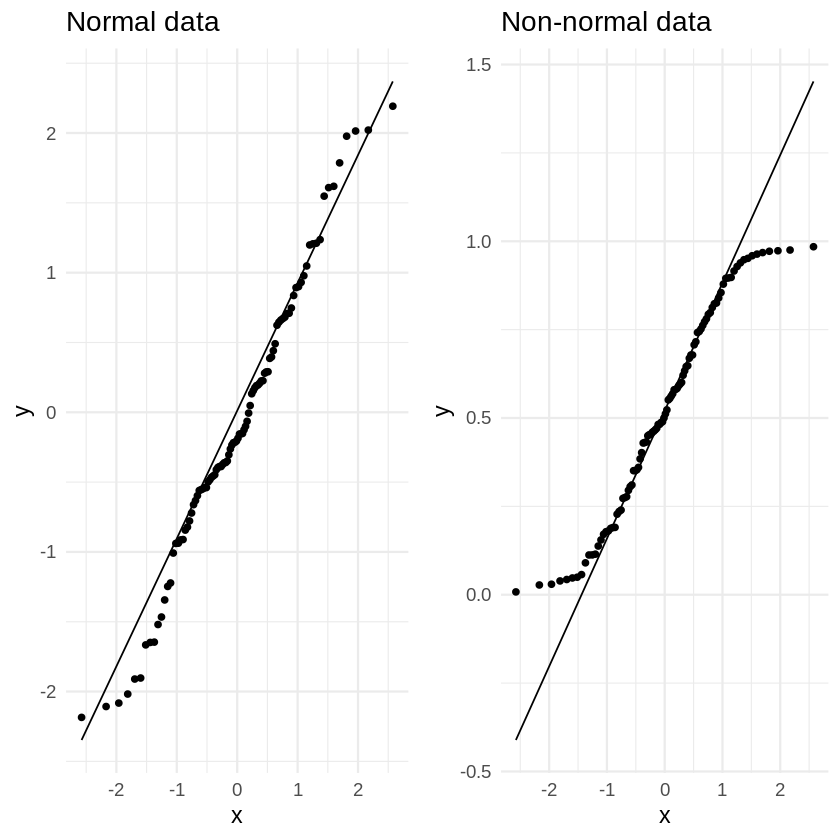

In [14]:
qq_df <- tibble(norm=rnorm(100),
                unif=runif(100))

p1 <- ggplot(qq_df,aes(sample=norm)) +
  geom_qq() +
  geom_qq_line() +
  ggtitle('Normal data')

p2 <- ggplot(qq_df,aes(sample=unif)) +
  geom_qq() +
  geom_qq_line()+
  ggtitle('Non-normal data')

plot_grid(p1,p2)

## Table 14.2

In [15]:
# create dataframe with children with complete data on all variables
set.seed(12345)

NHANES_child <-
  NHANES %>%
  drop_na(Height, Weight, TVHrsDayChild, HHIncomeMid, CompHrsDayChild, Age) %>%
  dplyr::filter(Age < 18)

# create function to sample data and compute regression on in-sample and out-of-sample data

get_sample_predictions <- function(sample_size, shuffle = FALSE) {
  # generate a sample from NHANES
  orig_sample <-
    NHANES_child %>%
    sample_n(sample_size)

  # if shuffle is turned on, then randomly shuffle the weight variable
  if (shuffle) {
    orig_sample$Weight <- sample(orig_sample$Weight)
  }
  # compute the regression line for Weight, as a function of several
  # other variables (with all possible interactions between variables)
  heightRegressOrig <- lm(
    Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age,
    data = orig_sample
  )
  # compute the predictions
  pred_orig <- predict(heightRegressOrig)

  # create a new sample from the same population
  new_sample <-
    NHANES_child %>%
    sample_n(sample_size)

  # use the model fom the original sample to predict the
  # Weight values for the new sample
  pred_new <- predict(heightRegressOrig, new_sample)

  # return r-squared and rmse for original and new data
  return(c(
    cor(pred_orig, orig_sample$Weight)**2,
    cor(pred_new, new_sample$Weight)**2,
    sqrt(mean((pred_orig - orig_sample$Weight)**2)),
    sqrt(mean((pred_new - new_sample$Weight)**2))
  ))
}

# implement the function
sim_results <-
  replicate(100, get_sample_predictions(sample_size = 48, shuffle = FALSE))

sim_results <-
  t(sim_results) %>%
  data.frame()

mean_rsquared <-
  sim_results %>%
  summarize(
    `RMSE (original data)` = mean(X3),
    `RMSE (new data)` = mean(X4)
  )

# using shuffled y variable to simulate null effect

sim_results <-
  replicate(100, get_sample_predictions(sample_size = 48, shuffle = TRUE))

sim_results <-
  t(sim_results) %>%
  data.frame()

mean_rsquared_sim <-
  sim_results %>%
  summarize(
    `RMSE (original data)` = mean(X3),
    `RMSE (new data)` = mean(X4)
  )
combined_rsquared = rbind(mean_rsquared, mean_rsquared_sim) %>%
  mutate(`Data type`=c('True data', 'Shuffled data')) %>%
  dplyr::select(`Data type`,`RMSE (original data)`,`RMSE (new data)`)
kable(combined_rsquared, caption='Root mean squared error for model applied to original data and new data, and after shuffling the order of the y variable (in essence making the null hypothesis true)')



Table: Root mean squared error for model applied to original data and new data, and after shuffling the order of the y variable (in essence making the null hypothesis true)

|Data type     | RMSE (original data)| RMSE (new data)|
|:-------------|--------------------:|---------------:|
|True data     |             3.025431|        24.60007|
|Shuffled data |             7.814364|        58.87935|

## Table 14.3

In [16]:
# create a function to run cross-validation
# returns the r-squared for the out-of-sample prediction
set.seed(12345)
compute_cv <- function(d, nfolds = 6) {
  # based on https://quantdev.ssri.psu.edu/tutorials/cross-validation-tutorial
  train_ctrl <- trainControl(method = "cv", number = nfolds)
  model_caret <- train(
    Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age,
    data = d,
    trControl = train_ctrl, # folds
    method = "lm"
  ) # specifying regression model

  r2_cv <- mean(model_caret$resample$Rsquared)
  rmse_cv <- mean(model_caret$resample$RMSE)
  return(c(r2_cv, rmse_cv))
}

# create function to sample data and compute regression on in-sample and out-of-sample data

get_sample_predictions_cv <- function(sample_size, shuffle = FALSE) {
  orig_sample <-
    NHANES_child %>%
    sample_n(sample_size)

  if (shuffle) {
    orig_sample$Weight <- sample(orig_sample$Weight)
  }

  heightRegressOrig <- lm(
    Weight ~ Height * TVHrsDayChild * CompHrsDayChild * HHIncomeMid * Age,
    data = orig_sample
  )

  pred_orig <- predict(heightRegressOrig)

  new_sample <-
    NHANES_child %>%
    sample_n(sample_size)

  pred_new <- predict(heightRegressOrig, new_sample)
  # run crossvalidation on original sample
  cv_output <- compute_cv(orig_sample) #use function created above
  return(c(
    cor(pred_orig, orig_sample$Weight)**2,
    cor(pred_new, new_sample$Weight)**2,
    cv_output[1],
    sqrt(mean((pred_orig - orig_sample$Weight)**2)),
    sqrt(mean((pred_new - new_sample$Weight)**2)),
    cv_output[2]
  ))
}

#implement the function
sim_results <-
  replicate(1000, get_sample_predictions_cv(sample_size = 48, shuffle = FALSE))

sim_results <-
  t(sim_results) %>%
  data.frame()

mean_rsquared <-
  sim_results %>%
  summarize(
    `Original data` = mean(X1),
    `New data` = mean(X2),
    `Cross-validation` = mean(X3)
  )

mean_rsquared_t = as.data.frame(t(mean_rsquared)) %>%
  rename(`R-squared`=V1)

kable(mean_rsquared_t, digits=3, caption="R-squared from cross-validation and new data, showing that cross-validation provides a reasonable estimate of the model's performance on new data.")

Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFit, newdata):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(modelFi



Table: R-squared from cross-validation and new data, showing that cross-validation provides a reasonable estimate of the model's performance on new data.

|                 | R-squared|
|:----------------|---------:|
|Original data    |     0.947|
|New data         |     0.334|
|Cross-validation |     0.355|

## Table 14.4

In [17]:
df <-
  tibble(
    studyTime = c(2, 3, 5, 6, 6, 8, 10, 12) / 3,
    priorClass = c(0, 1, 1, 0, 1, 0, 1, 0)
  ) %>%
  mutate(
    grade =
      studyTime * betas[1] +
      priorClass * betas[2] +
      round(rnorm(8, mean = 70, sd = 5))
  )

df_matrix <-
  df %>%
  dplyr::select(studyTime, grade) %>%
  as.matrix()

kable(df_matrix, caption='Study time data reformatted as a matrix.')



Table: Study time data reformatted as a matrix.

| studyTime| grade|
|---------:|-----:|
| 0.6666667|    76|
| 1.0000000|    84|
| 1.6666667|    76|
| 2.0000000|    83|
| 2.0000000|    96|
| 2.6666667|    79|
| 3.3333333|    92|
| 4.0000000|    98|

## Table 14.5

In [18]:
# compute beta estimates using linear algebra

#create Y variable 8 x 1 matrix
Y <- as.matrix(df$grade)
 #create X variable 8 x 2 matrix
X <- matrix(0, nrow = 8, ncol = 2)
#assign studyTime values to first column in X matrix
X[, 1] <- as.matrix(df$studyTime)
#assign constant of 1 to second column in X matrix
X[, 2] <- 1

# compute inverse of X using ginv()
# %*% is the R matrix multiplication operator

beta_hat <- ginv(X) %*% Y #multiple the inverse of X by Y

beta_df = data.frame(parameter=c('Beta 1', 'Beta 2'), estimate=beta_hat)
kable(beta_df, digits=1, caption='Regression parameters estimated using linear algebra.')



Table: Regression parameters estimated using linear algebra.

|parameter | estimate|
|:---------|--------:|
|Beta 1    |      5.2|
|Beta 2    |     74.1|